# Baseline Model – XGBoost for Short-Range Wind Power Forecasting

To complement the ElasticNet baseline and provide a **nonlinear benchmark**, I evaluated **XGBoost regression** under the same experimental setup, using varying proportions of labeled data.

XGBoost was selected for its robustness, ability to handle feature interactions, and effectiveness on tabular data—making it well-suited for the wind power forecasting task.

Key steps:

* The dataset was temporally ordered, and the final **10% of data was reserved as the test set**, maintaining realistic forecasting conditions through a **time-based split**.
* A **GridSearchCV** with `TimeSeriesSplit` was employed to tune hyperparameters including `n_estimators`, `learning_rate`, and `max_depth`.
* Model performance was evaluated across **1%, 5%, 10%, 20%, and 100%** labeled data subsets using **MAE, RMSE, and R^2** metrics.
* Unlike ElasticNet, **no standardization was applied**, as tree-based models are scale-invariant.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import joblib
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

In [28]:
PERCENTAGES = [0.01, 0.05, 0.1, 0.2, 1.0]
RANDOM_STATE = 42

## 1. Load and Prepare Dataset

In [29]:
df = pd.read_csv("../data/processed/wtb_features.csv")
df = df.sort_values("Timestamp")

In [30]:
target = 'Patv'
drop_cols = ['Patv', 'Timestamp', 'TurbID']
X = df.drop(columns=drop_cols)
y = df[target]

results = {}

## 2. XGBoost + GridSearchCV

In [31]:
for pct in PERCENTAGES:
    print(f"\n--- Training XGBoost with {int(pct * 100)}% of labeled data ---")

    if pct < 1.0:
        X_train_full, _, y_train_full, _ = train_test_split(X, y, train_size=pct, shuffle=False)
    else:
        X_train_full = X.copy()
        y_train_full = y.copy()

    split_idx = int(len(X) * 0.9)
    X_test = X.iloc[split_idx:]
    y_test = y.iloc[split_idx:]

    model = XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE)

    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6],
        'subsample': [0.8],
        'colsample_bytree': [0.8]
    }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=TimeSeriesSplit(n_splits=5),
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train_full, y_train_full)

    y_pred = grid_search.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Best Params: {grid_search.best_params_}")
    print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R^2: {r2:.3f}")

    label = f"{int(pct * 100)}%"
    results[label] = {
        'best_params': grid_search.best_params_,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'R2': round(r2, 3)
    }

    joblib.dump(grid_search.best_estimator_, f"../models/xgboost_{label}.joblib")


--- Training XGBoost with 1% of labeled data ---
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
MAE: 118.49 | RMSE: 178.94 | R^2: 0.779

--- Training XGBoost with 5% of labeled data ---
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
MAE: 72.18 | RMSE: 108.88 | R^2: 0.918

--- Training XGBoost with 10% of labeled data ---
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
MAE: 66.40 | RMSE: 101.42 | R^2: 0.929

--- Training XGBoost with 20% of labeled data ---
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
MAE: 62.43 | RMSE: 97.36 | R^2: 0.935

--- Training XGBoost with 100% of labeled data ---
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
MAE: 31.02

In [32]:
with open("../results/xgboost_semisupervised_scores.json", "w") as f:
    json.dump(results, f, indent=4)

## 3. Model Evaluation

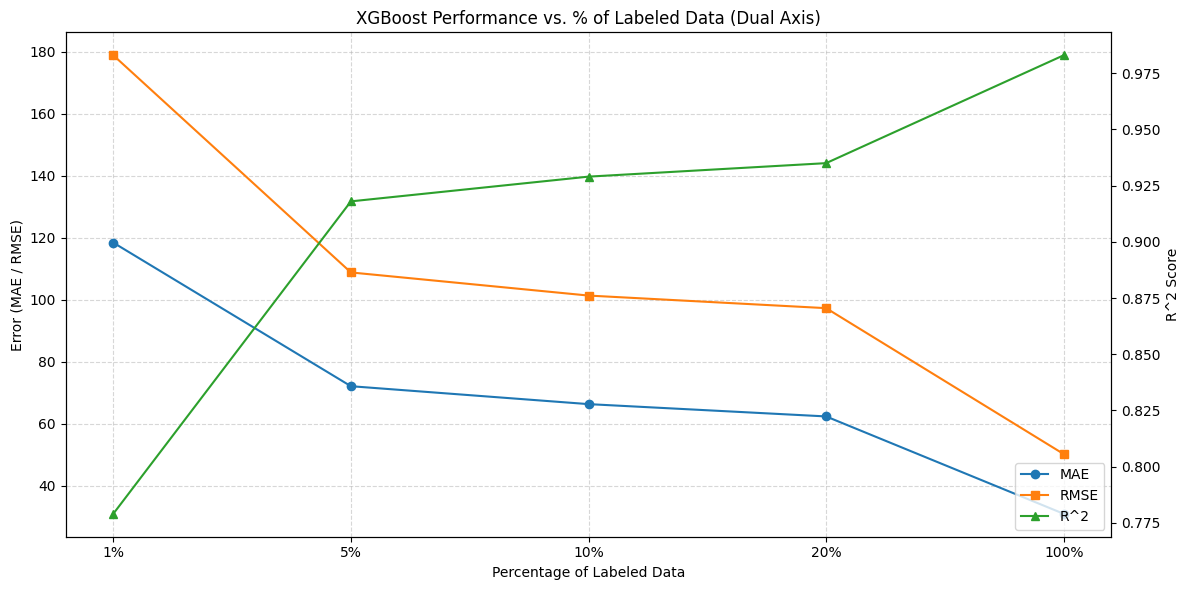

In [33]:
labels = list(results.keys())
maes = [results[k]['MAE'] for k in labels]
rmses = [results[k]['RMSE'] for k in labels]
r2s = [results[k]['R2'] for k in labels]

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel("Percentage of Labeled Data")
ax1.set_ylabel("Error (MAE / RMSE)")
ax1.plot(labels, maes, marker='o', label="MAE", color='tab:blue')
ax1.plot(labels, rmses, marker='s', label="RMSE", color='tab:orange')
ax1.tick_params(axis='y')
ax1.grid(True, linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.set_ylabel("R^2 Score")
ax2.plot(labels, r2s, marker='^', label="R^2", color='tab:green')
ax2.tick_params(axis='y')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

plt.title("XGBoost Performance vs. % of Labeled Data (Dual Axis)")
plt.tight_layout()
plt.show()

#### Results:

| % Labeled | MAE    | RMSE   | R^2    | Best Params                                            |
| --------- | ------ | ------ | ----- | ------------------------------------------------------ |
| 1%        | 118.49 | 178.94 | 0.779 | `n_estimators`=200, `learning_rate`=0.1, `max_depth`=3 |
| 5%        | 72.18  | 108.88 | 0.918 | `n_estimators`=200, `learning_rate`=0.1, `max_depth`=6 |
| 10%       | 66.40  | 101.42 | 0.929 | `n_estimators`=200, `learning_rate`=0.1, `max_depth`=6 |
| 20%       | 62.43  | 97.36  | 0.935 | `n_estimators`=200, `learning_rate`=0.1, `max_depth`=6 |
| 100%      | 31.02  | 50.29  | 0.983 | `n_estimators`=200, `learning_rate`=0.1, `max_depth`=6 |

#### Observations:

* **With only 1% labeled data**, XGBoost already achieves a strong **R^2 of 0.779**, far outperforming linear models at this level of supervision.
* Performance improves sharply at 5%, reaching **R^2 = 0.918**, indicating that even small label sets are enough for gradient-boosted trees to learn complex dynamics.
* From 10% to 20% labeled data, the gains continue but start to plateau, suggesting diminishing returns past a certain supervision threshold.
* At 100% labeled data, the model achieves **excellent accuracy**, with **RMSE = 50.29** and **R^2 = 0.983**, establishing a very strong fully-supervised benchmark.
* The best hyperparameters are **consistent across runs**, especially favoring a learning rate of 0.1, max depth of 6, and 200 estimators—reflecting a balance between model complexity and generalization.

These results confirm that **XGBoost is highly data-efficient and nonlinear**, making it a strong competitor even under label-scarce conditions. Any semi-supervised method, such as S2RMS, must demonstrate **clear advantages in performance or data efficiency** to justify its added complexity.

Next, we will analyze the feature importances learned by XGBoost to better understand which inputs are most influential in forecasting wind turbine power output.

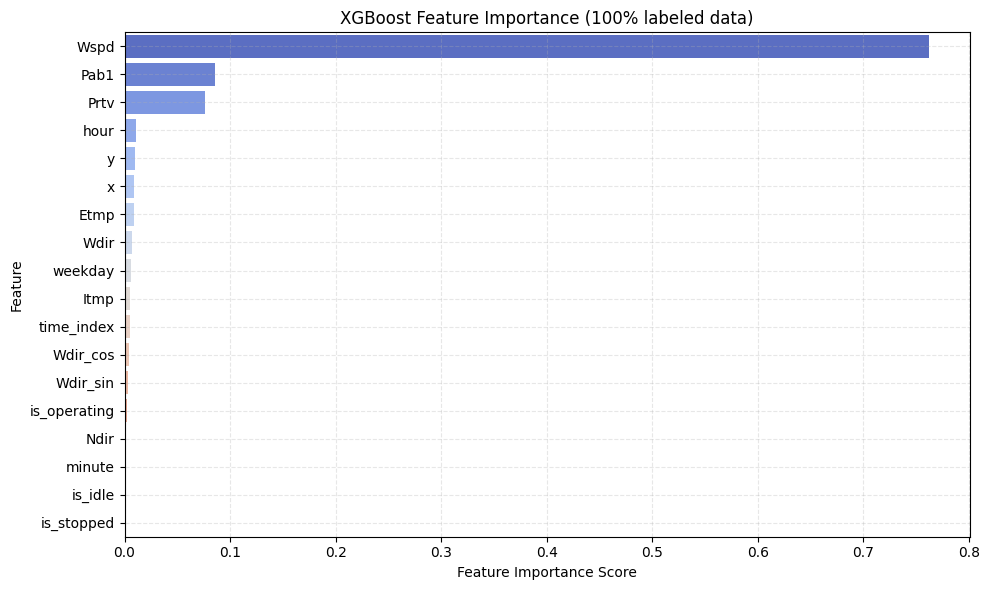

In [34]:
model_100 = joblib.load("../models/xgboost_100%.joblib")

feature_names = X.columns
importances = model_100.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_df,
    hue='Feature',
    palette='coolwarm',
    dodge=False,
    legend=False
)

plt.title("XGBoost Feature Importance (100% labeled data)")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


This analysis compares the feature importance derived from two distinct machine learning models, XGBoost and ElasticNet, both trained on 100% labeled data.

**Key Observations:**

1.  **Dominant Features:** Both XGBoost and ElasticNet consistently identify `Wspd` (Wind Speed) as the most crucial feature, exhibiting by far the highest importance/coefficient value. This strong agreement suggests `Wspd` is a fundamental predictor for the target variable across different modeling approaches. `Pab1` also shows significant importance in both models, though its relative ranking differs slightly.

2.  **Model-Specific Feature Prioritization:**
    * **XGBoost:** Beyond `Wspd` and `Pab1`, `Prtv` emerges as the third most important feature. Notably, `is\_operating`, `is\_idle`, and `is\_stopped` have negligible importance for XGBoost.
    * **ElasticNet:** While `Wspd` remains dominant, `Pab1` shows a strong negative correlation (large negative coefficient). Interestingly, `is\_operating` and `is\_idle` become significantly important in ElasticNet, with `is\_operating` having a negative coefficient and `is\_idle` a positive one.

3.  **Impact of Categorical/Binary Features:**
    * XGBoost, a tree-based model, assigns very low importance to binary/categorical features like `is\_operating`, `is\_idle`, and `is\_stopped`. This might suggest that their information is either implicitly captured by other continuous features or that their individual split gains are not significant enough in the tree ensemble.
    * ElasticNet, a linear model with regularization, assigns substantial coefficients to `is\_operating` and `is\_idle`. This indicates that these features have a direct, linear relationship (positive or negative) with the target variable that ElasticNet effectively leverages.